In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import ndimage

### #1

In [13]:
# X_train = np.load("../data/generator/generated_data.npy")
# Y_train = np.load("../data/generator/generated_data_labels.npy")
#
# X_train.shape, Y_train.shape

In [14]:
# X_train_ = np.repeat(X_train[..., np.newaxis], 3, -1)
# X_train_.shape

In [15]:
# y_train = np.zeros(Y_train.shape)
#
# y_train[Y_train == "attack"] = 1
# y_train[Y_train == "block"] = 2
# y_train[Y_train == "counterattack"] = 3
# y_train[Y_train == "cover"] = 4
# y_train[Y_train == "delay"] = 5
# y_train[Y_train == "destroy"] = 6
# y_train[Y_train == "disrupt"] = 7
# y_train[Y_train == "guard"] = 8
# y_train[Y_train == "occupy"] = 9
# y_train[Y_train == "retain"] = 10
# y_train[Y_train == "screen"] = 11
# y_train[Y_train == "secure"] = 12
# y_train[Y_train == "seize"] = 13
# y_train[Y_train == "support_by_fire"] = 14

### #2

In [40]:
Y_train = []
X_train = []

for angle in ([0, 45, 90, 135, 180, 225, 270, 315]):
    for filename in os.listdir("./train_data/"):
        img = cv2.imread("./train_data/" + filename)
        img2 = ndimage.rotate(img, angle, mode = "constant", cval = 255)
        img3 = cv2.resize(img2, [100,100])
        name = re.findall('([a-zA-Z_ ]*)\d*.*', filename)[0]
        X_train.append(img3)
        Y_train.append(name)

sharpening = np.array([[-1, -1, -1],
                       [-1, 10, -1],
                       [-1, -1, -1]])

for angle in ([0, 45, 90, 135, 180, 225, 270, 315]):
    for filename in os.listdir("./train_data/"):
        img = cv2.imread("./train_data/" + filename)
        img2 = ndimage.rotate(img, angle, mode = "constant", cval = 255)
        img3 = cv2.resize(img2, [100,100])
        img4 = cv2.filter2D(img3, -1, sharpening)
        name = re.findall('([a-zA-Z_ ]*)\d*.*', filename)[0]
        X_train.append(img3)
        Y_train.append(name)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train.shape, Y_train.shape

((7200, 100, 100, 3), (7200,))

In [41]:
X_train = X_train / 255.

In [42]:
y_train = np.zeros(Y_train.shape)

y_train[Y_train == "attack"] = 1
y_train[Y_train == "block"] = 2
y_train[Y_train == "counterattack"] = 3
y_train[Y_train == "cover"] = 4
y_train[Y_train == "delay"] = 5
y_train[Y_train == "destroy"] = 6
y_train[Y_train == "disrupt"] = 7
y_train[Y_train == "guard"] = 8
y_train[Y_train == "occupy"] = 9
y_train[Y_train == "retain"] = 10
y_train[Y_train == "screen"] = 11
y_train[Y_train == "secure"] = 12
y_train[Y_train == "seize"] = 13
y_train[Y_train == "support_by_fire"] = 14

In [43]:
np.random.RandomState(seed=22).shuffle(X_train)
np.random.RandomState(seed=22).shuffle(y_train)

## Model

In [44]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(100, 100, 3),
    include_top=False)

base_model.trainable = False

In [45]:
inputs = keras.Input(shape=(100, 100, 3))

x = base_model(inputs, training=False)
x = keras.layers.Dense(256, activation = "relu")(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(15, activation = "softmax")(x)
model = keras.Model(inputs, outputs)

In [46]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=64, epochs=30)

Epoch 1/30
113/113 [==============================] - 38s 326ms/step - loss: 0.9025 - accuracy: 0.7136
Epoch 2/30
113/113 [==============================] - 35s 313ms/step - loss: 0.3164 - accuracy: 0.8890
Epoch 3/30
113/113 [==============================] - 36s 315ms/step - loss: 0.1748 - accuracy: 0.9444
Epoch 4/30
113/113 [==============================] - 36s 323ms/step - loss: 0.1333 - accuracy: 0.9554
Epoch 5/30
113/113 [==============================] - 35s 312ms/step - loss: 0.0877 - accuracy: 0.9736
Epoch 6/30
113/113 [==============================] - 35s 312ms/step - loss: 0.0609 - accuracy: 0.9843
Epoch 7/30
113/113 [==============================] - 35s 314ms/step - loss: 0.0338 - accuracy: 0.9928
Epoch 8/30
113/113 [==============================] - 35s 312ms/step - loss: 0.0272 - accuracy: 0.9946
Epoch 9/30
113/113 [==============================] - 36s 314ms/step - loss: 0.0280 - accuracy: 0.9935
Epoch 10/30
113/113 [==============================] - 35s 313ms/step - l

In [47]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dense_6 (Dense)             (None, 3, 3, 256)         524544    
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_7 (Dense)             (None, 15)                34575     
                                                                 
Total params: 21,420,599
Trainable params: 559,119
Non-trainable params: 20,861,480
_________________________________________________________________


## Testing

In [48]:
X_test = []
Y_test = []

for filename in os.listdir("./test_data/"):
    img = cv2.imread("./test_data/" + filename)
    name = re.findall('([a-zA-Z_ ]*)\d*.*', filename)[0]
    X_test.append(img)
    Y_test.append(name)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [49]:
X_test = X_test / 255.

In [50]:
y_test = np.zeros(Y_test.shape)

y_test[Y_test == "attack"] = 1
y_test[Y_test == "block"] = 2
y_test[Y_test == "counterattack"] = 3
y_test[Y_test == "cover"] = 4
y_test[Y_test == "delay"] = 5
y_test[Y_test == "destroy"] = 6
y_test[Y_test == "disrupt"] = 7
y_test[Y_test == "guard"] = 8
y_test[Y_test == "occupy"] = 9
y_test[Y_test == "retain"] = 10
y_test[Y_test == "screen"] = 11
y_test[Y_test == "secure"] = 12
y_test[Y_test == "seize"] = 13
y_test[Y_test == "support_by_fire"] = 14

In [51]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 4s 169ms/step - loss: 3.5876 - accuracy: 0.5009


[3.5875508785247803, 0.5008547306060791]

In [52]:
preds = model.predict(X_test)

correct = np.sum(np.abs(np.argmax(preds, axis=1)-y_test) == 0)
print("Correct: " + str(correct))
print("Total: " + str(X_test.shape[0]))
print("Acc: " + str(correct/X_test.shape[0]))

Correct: 293
Total: 585
Acc: 0.5008547008547009


In [53]:
cm = confusion_matrix(y_test, np.argmax(preds, axis=1))

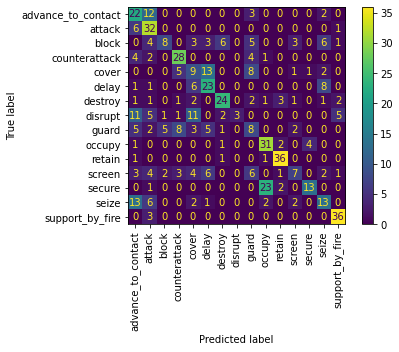

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["advance_to_contact",
                                                            "attack",
                                                            "block",
                                                            "counterattack",
                                                            "cover",
                                                            "delay",
                                                            "destroy",
                                                            "disrupt",
                                                            "guard",
                                                            "occupy",
                                                            "retain",
                                                            "screen",
                                                            "secure",
                                                            "seize",
                                                            "support_by_fire"])

disp.plot(xticks_rotation= "vertical")